In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from czmodel.pytorch.convert import DefaultConverter
import tempfile
from pathlib import Path
import onnxruntime as onnx_rt
from pylibCZIrw import czi as pyczi
import tifffile

In [2]:
#czifile = "6well_1_s3_t5_1024.czi"
czifile = "grains_big.czi"
#czann_filepath = "organoids.czann"
czann_filepath = "REM_AL2O3_Grains_8bit.czann"

In [3]:
def predict_one(sess: onnx_rt.InferenceSession, batch_elem: np.ndarray) -> np.ndarray:
    """Predicts with a batch size of 1 to not risk memory issues.

    Arguments:
        sess: The inference session containing the loaded model.
        batch_elem: One element of a batch to be used for prediction.

    Returns:
        The prediction for the provided batch element.
    """
    batch_elem = batch_elem[np.newaxis]
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    # ONNX can only handle float32
    batch_elem = batch_elem.astype(np.float32)
    input_dict = {input_name: batch_elem}
    result = sess.run([output_name], input_dict)[0]

    return result[0]

In [4]:
# extract the model information and path and to the prediction
with tempfile.TemporaryDirectory() as temp_path:

    # get the model metadata and the path
    model_metadata, model_path = DefaultConverter().unpack_model(model_file=czann_filepath,
                                                                 target_dir=Path(temp_path))

    # get model metadata as dictionary
    model_metadata_dict = model_metadata._asdict()
    for k,v in model_metadata_dict.items():
        print(k, "=", v)

    # get the input shape
    shp = model_metadata.input_shape

    # create an ONNX session and get the input shape
    # use either "CUDAExecutionProvider" or "CPUExecutionProvider"]
    sess = onnx_rt.InferenceSession(str(model_path), providers=["CPUExecutionProvider"])
    
    num_classes = len(model_metadata_dict["classes"])

model_type = ModelType.SINGLE_CLASS_SEMANTIC_SEGMENTATION
input_shape = [1024, 1024, 1]
output_shape = [1024, 1024, 3]
model_id = 3738fa09-8cfa-40d1-b5f1-3fe50e23e9e4
min_overlap = [128, 128]
classes = ['background', 'grains', 'inclusions']
model_name = APEER-trained model
scaling = None


In [6]:
# make sure that the image has the correct inputs size
xstart = 0
ystart = 0
ch = 0
t = 0
z = 0
s = 0
my_roi = (xstart, ystart, model_metadata_dict["input_shape"][0], model_metadata_dict["input_shape"][1])

with pyczi.open_czi(czifile) as czidoc:
    
    # define plane coordinates and read the image
    img = czidoc.read(plane={"C": ch, "Z": z, "T": t}, scene=s, roi=my_roi)[...,0]
    
    # scale !!! - needs to adpated based on the image used for training
    if czidoc.get_channel_pixel_type(0) == "Gray8":
        img_sc = img / (2**8 - 1)
    if czidoc.get_channel_pixel_type(0) == "Gray16":
        img_sc = img / (2**16 - 1)

# run the raw prediction
pred_raw = predict_one(sess, img_sc[..., np.newaxis])

# get the labels (starting with zero)
pred = np.argmax(pred_raw, axis=-1)

In [7]:
# create subimages
subimage = True
si = np.s_[400:800, 400:800]

if subimage:
    img = img[si]
    img_sc = img_sc[si]
    pred_raw = pred_raw[si]
    pred = pred[si]

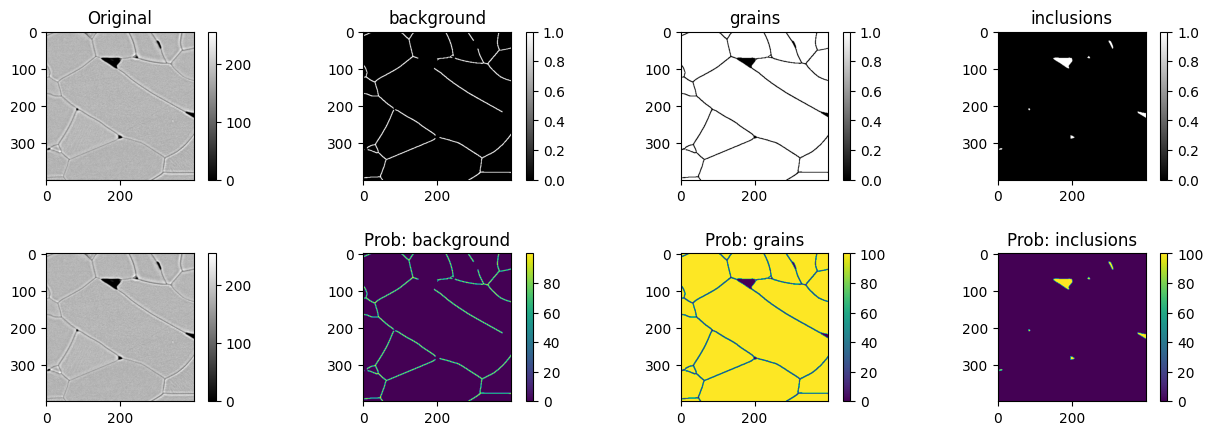

In [10]:
save_results = True
basename = czifile[:-4]

fig, axs = plt.subplots(2, num_classes + 1)
fig.set_figwidth(16)

# show images and set titles
i1 = axs[0, 0].imshow(img, cmap="gray")
i2 = axs[1, 0].imshow(img, cmap="gray")
axs[0, 0].set_title("Original")
fig.colorbar(i1, ax=axs[0, 0])
fig.colorbar(i1, ax=axs[1, 0])

# optional: save the original image as TIFF
if save_results:
    tifffile.imwrite(basename + "_orig.tiff", img)

# show classes
for c in range(num_classes):

    # get the predicted mask for each class and display it
    pred_c = np.where(pred == c, 1, 0)
    p1 = axs[0, c+1].imshow(pred_c, cmap="gray")
    axs[0, c+1].set_title(model_metadata_dict["classes"][c])
    fig.colorbar(p1, ax=axs[0, c+1])
    
    # show the probabilty values (0-100) for each class and display it
    p2 = axs[1, c+1].imshow(pred_raw[...,c] * 100)
    axs[1, c+1].set_title("Prob: " + model_metadata_dict["classes"][c])
    fig.colorbar(p2, ax=axs[1, c+1])
    
    # optional: save the results as TIFFs
    if save_results:     
        tifffile.imwrite(basename + "_" + model_metadata_dict["classes"][c] + ".tiff", pred_c)
        tifffile.imwrite(basename + "_prob_" + model_metadata_dict["classes"][c] + ".tiff", pred_raw[..., c] * 100)

# adjust the spacing
plt.subplots_adjust(hspace=0.5, wspace=0.1)